Instala e importa dependências

In [ ]:
!pip install PyPortfolioOpt
!pip install cvxpy
!pip install pybind11
!pip install riskfolio-lib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.0/301.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.0/983.0 kB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 kB 40.2 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attemptin

In [ ]:
import pandas as pd
import numpy as np
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import objective_functions
import matplotlib.pyplot as plt
import seaborn as sns
from pypfopt import CLA, plotting
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import datetime
from pypfopt import HRPOpt
from pypfopt import plotting


Import ETFs and BDR ETFs data

In [ ]:
#%% ETFs and BDR ETFs
#File Path
from google.colab import files

# Upload the file
uploaded = files.upload()

# The uploaded file is stored in a dictionary with the filename as the key
# and the file contents as the value
for fn in uploaded.keys():
  # Do something with the file
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))



Saving Base.xlsx to Base.xlsx
User uploaded file "Base.xlsx" with length 1867165 bytes


In [ ]:
# Use pandas to read the Excel file
etfs_finvol = pd.read_excel('Base.xlsx', #Workbook
                   sheet_name = 'ETF Fin Vol', #Spreadsheet name
                   usecols = range(1,20), #Specify columns to use
                   skiprows = 2, #Skip first two rows
                   nrows = 278, #Specify quantity of rows to use
                   header = None) #No headers


#Display contents of DATAFRAME
print(etfs_finvol)

#Name ETFs
etfs_finvol.columns = ['BNDX11', 'USDB11', 'WRLD11', 'ALUG11', 'SMAL11', 'BOVA11', 'IVVB11', 'BOVV11', 'IMAB11', 'DIVO11',
                       'B5P211', 'IB5M11', 'IRFM11', 'SPXI11', 'SMAC11', 'URET11', 'XFIX11', 'GOLD11', 'ACWI11']

#Mean Financial Vol
etfs_finvol.tail(12) #Take last 12 months of negotiation
etfs_finvol_colmeans = np.mean(etfs_finvol.tail(12), axis = 0)

# Convert to Pandas Series and set float_format
etfs_finvol_colmeans_series = pd.Series(etfs_finvol_colmeans)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Print the result
print("\nDaily financial volume means of the last 12 months:")
print(etfs_finvol_colmeans_series)

# Use pandas to read the Excel file
bdrs_finvol = pd.read_excel('Base.xlsx', #Workbook path
                   sheet_name = 'BDR ETF Fin Vol', #Spreadsheet name
                   usecols = range(1,12), #Specify columns to use
                   skiprows = 2, #Skip first two rows
                   nrows = 40, #Specify quantity of rows to use
                   header = None) #No headers

#Display contents of DATAFRAME
print(bdrs_finvol)

#Name ETFs
bdrs_finvol.columns = ['BSRE39', 'BTLT39', 'BIEI39', 'BIYT39', 'BUSR39', 'BGRT39', 'BIAU39', 'BCOM39', 'BSHV39', 'BGOV39',
                       'BIPZ39']


#Mean Financial Vol
bdrs_finvol.tail(12) #Take last 12 months of negotiation
bdrs_finvol_colmeans = np.mean(bdrs_finvol.tail(12), axis = 0)

# Convert to Pandas Series and set float_format
bdrs_finvol_colmeans_series = pd.Series(bdrs_finvol_colmeans)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Print the result
print("\nDaily financial volume means of the last 12 months:")
print(bdrs_finvol_colmeans_series)

FileNotFoundError: [Errno 2] No such file or directory: 'Base.xlsx'

Indexes Data

In [ ]:
# Use pandas to read the Excel file
assets_returns = pd.read_excel('Base.xlsx', #Workbook path
                   sheet_name = 'Indexes Returns', #Spreadsheet name
                   usecols = range(1,46), #Specify columns to use
                   skiprows = 2, #Skip first two rows
                   nrows = 289, #Specify quantity of rows to use
                   header = None #No headers
                   )



#Subset more liquid options
assets_returns_selected = assets_returns.iloc[:,# All rows
                                              [   0,#CDI
                                                  2, #FTSE Nareit Equty REITs
                                                  6, #MSCI US IMI/Real Estate 25-50
                                                  12, #7-10 Treasury
                                                  14, #20+ Treasury
                                                  16, #General TIPS
                                                  24, #Ibov
                                                  27, #IHFA
                                                  28, #IMA-B
                                                  29, #IMA-B 5
                                                  30, #IMA-B 5+
                                                  31, #IRF-M
                                                  32, #MSCI ACWI
                                                  36,#Gold
                                                  37 #S&P 500
                                                  ]]

#Change Col names
assets_returns_selected.columns = ['CDI', 'FTSE Nareit', 'MSCI IMI/RE 25-50', 'ICE US 7-10 TR','ICE US 20+ TR',
                                   'ICE US TIPS', 'IBOV', 'IHFA', 'IMA-B', 'IMA-B 5', 'IMA-B 5+', 'IRF-M',
                                   'MSCI ACWI', 'GOLD', 'S&P 500']

#Print
print(assets_returns_selected)
display(assets_returns_selected)

          CDI  FTSE Nareit  MSCI IMI/RE 25-50  ICE US 7-10 TR  ICE US 20+ TR  \
0    0.014418     0.010808                NaN             NaN            NaN   
1    0.014403    -0.030497                NaN             NaN            NaN   
2    0.014402     0.020498                NaN             NaN            NaN   
3    0.012835     0.103472                NaN             NaN            NaN   
4    0.014884     0.020959                NaN             NaN            NaN   
..        ...          ...                ...             ...            ...   
284  0.009747    -0.051814          -0.065581       -0.014548      -0.063711   
285  0.009976    -0.034119          -0.017140       -0.009561      -0.045371   
286  0.009178     0.078917           0.093780        0.020150       0.072437   
287  0.008963     0.078220           0.060486        0.015028       0.062973   
288  0.009667    -0.019291          -0.016606        0.029694       0.006604   

     ICE US TIPS      IBOV      IHFA   

,CDI,FTSE Nareit,MSCI IMI/RE 25-50,ICE US 7-10 TR,ICE US 20+ TR,ICE US TIPS,IBOV,IHFA,IMA-B,IMA-B 5,IMA-B 5+,IRF-M,MSCI ACWI,GOLD,S&P 500
0,0.014418,0.010808,NaN,NaN,NaN,NaN,-0.041133,NaN,NaN,NaN,NaN,NaN,-0.047929,-0.016634,-0.043795
1,0.014403,-0.030497,NaN,NaN,NaN,NaN,0.077618,NaN,NaN,NaN,NaN,NaN,-0.016504,0.017038,-0.038538
2,0.014402,0.020498,NaN,NaN,NaN,NaN,0.009060,NaN,NaN,NaN,NaN,0.019458,0.051844,-0.068849,0.083573
3,0.012835,0.103472,NaN,NaN,NaN,NaN,-0.128114,NaN,NaN,NaN,NaN,0.006641,-0.013470,0.027644,0.002153
4,0.014884,0.020959,NaN,NaN,NaN,NaN,-0.037395,NaN,NaN,NaN,NaN,0.014459,-0.016386,0.000722,-0.011142
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,0.009747,-0.051814,-0.065581,-0.014548,-0.063711,-0.003073,0.007114,0.000054,-0.009457,0.001331,-0.019233,0.001710,-0.026078,-0.020198,-0.032156
285,0.009976,-0.034119,-0.017140,-0.009561,-0.045371,0.004064,-0.029353,-0.008583,-0.006557,-0.003113,-0.009768,0.003741,-0.021042,0.078214,-0.012234
286,0.009178,0.078917,0.093780,0.020150,0.072437,0.000215,0.125393,0.025201,0.026243,0.018037,0.033942,0.024693,0.064359,-0.005283,0.062905
287,0.008963,0.078220,0.060486,0.015028,0.062973,0.006788,0.053829,0.026520,0.027507,0.014621,0.039430,0.014812,0.026989,0.001612,0.024299


Calculate correlation

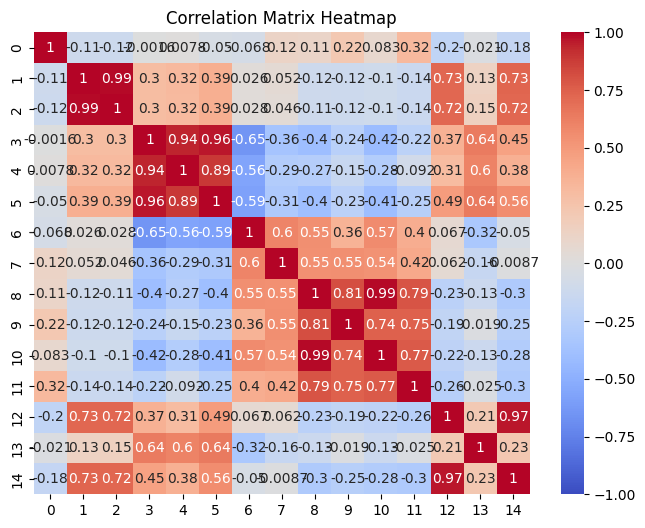

In [ ]:
corr_matrix = np.corrcoef(assets_returns_selected.dropna(), rowvar = False) #Ignore NAs


# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix Heatmap')
plt.show()

# Drop assets based on correlation
assets_returns_selected = assets_returns_selected.drop(columns = ['MSCI IMI/RE 25-50', 'ICE US TIPS'],
                                                       axis = 1) #drop columns





In [ ]:
display(assets_returns_selected)
np.mean(assets_returns_selected, axis = 0)

,CDI,FTSE Nareit,ICE US 7-10 TR,ICE US 20+ TR,IBOV,IHFA,IMA-B,IMA-B 5,IMA-B 5+,IRF-M,MSCI ACWI,GOLD,S&P 500
0,0.014418,0.010808,NaN,NaN,-0.041133,NaN,NaN,NaN,NaN,NaN,-0.047929,-0.016634,-0.043795
1,0.014403,-0.030497,NaN,NaN,0.077618,NaN,NaN,NaN,NaN,NaN,-0.016504,0.017038,-0.038538
2,0.014402,0.020498,NaN,NaN,0.009060,NaN,NaN,NaN,NaN,0.019458,0.051844,-0.068849,0.083573
3,0.012835,0.103472,NaN,NaN,-0.128114,NaN,NaN,NaN,NaN,0.006641,-0.013470,0.027644,0.002153
4,0.014884,0.020959,NaN,NaN,-0.037395,NaN,NaN,NaN,NaN,0.014459,-0.016386,0.000722,-0.011142
...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,0.009747,-0.051814,-0.014548,-0.063711,0.007114,0.000054,-0.009457,0.001331,-0.019233,0.001710,-0.026078,-0.020198,-0.032156
285,0.009976,-0.034119,-0.009561,-0.045371,-0.029353,-0.008583,-0.006557,-0.003113,-0.009768,0.003741,-0.021042,0.078214,-0.012234
286,0.009178,0.078917,0.020150,0.072437,0.125393,0.025201,0.026243,0.018037,0.033942,0.024693,0.064359,-0.005283,0.062905
287,0.008963,0.078220,0.015028,0.062973,0.053829,0.026520,0.027507,0.014621,0.039430,0.014812,0.026989,0.001612,0.024299


CDI               0.009544
FTSE Nareit       0.013340
ICE US 7-10 TR    0.006266
ICE US 20+ TR     0.007344
IBOV              0.009500
IHFA              0.008399
IMA-B             0.010899
IMA-B 5           0.010102
IMA-B 5+          0.011831
IRF-M             0.010639
MSCI ACWI         0.007195
GOLD              0.012160
S&P 500           0.008862
dtype: float64

Fill IHFA Data

In [ ]:
#X are regressors
ihfa_fill = assets_returns_selected.dropna() #Select rows without NA in IHFA
ihfa_fill_X = ihfa_fill.drop(columns = ['IHFA'], axis = 1)
ihfa_fill_X = sm.add_constant(ihfa_fill_X) #add a constant
ihfa_fill_Y = ihfa_fill.loc[:, 'IHFA'] #Y is IHFA


model = sm.OLS(ihfa_fill_Y, ihfa_fill_X).fit() #Run OLS regression

print(model.summary())

new_data_X = assets_returns_selected[assets_returns_selected['IHFA'].isna()] #Subset only rows with NAs
new_data_X.drop(columns = ['IHFA'], axis = 1, inplace = True) #Remove IHFA
new_data_X.dropna(inplace = True) #Remove NaN rows


IHFA_fill = model.predict(sm.add_constant(new_data_X)) #Fill missing IHFA

assets_returns_selected_complete = assets_returns_selected.dropna(subset = ['IMA-B']) #Drop based on IMA-B

assets_returns_selected_complete['IHFA'].fillna(pd.Series(IHFA_fill), inplace = True) #Replace NaN in IHFA for predicted values



                            OLS Regression Results                            
Dep. Variable:                   IHFA   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     17.94
Date:                Mon, 18 Mar 2024   Prob (F-statistic):           4.18e-25
Time:                        13:01:15   Log-Likelihood:                 667.53
No. Observations:                 195   AIC:                            -1309.
Df Residuals:                     182   BIC:                            -1267.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0005      0.002     -0.

<ipython-input-6-fab7b89a7c72>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data_X.drop(columns = ['IHFA'], axis = 1, inplace = True) #Remove IHFA
<ipython-input-6-fab7b89a7c72>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data_X.dropna(inplace = True) #Remove NaN rows
<ipython-input-6-fab7b89a7c72>:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

In [ ]:
display(assets_returns_selected_complete)

,CDI,FTSE Nareit,ICE US 7-10 TR,ICE US 20+ TR,IBOV,IHFA,IMA-B,IMA-B 5,IMA-B 5+,IRF-M,MSCI ACWI,GOLD,S&P 500
45,0.016364,-0.005336,-0.036600,-0.052329,0.123173,0.025978,0.024294,0.020072,0.024783,0.018140,0.035083,-0.027394,0.030711
46,0.013432,0.077648,0.038223,0.036215,0.122400,0.018149,0.041061,0.020376,0.043733,0.021334,0.046745,0.064980,0.039992
47,0.013691,0.013855,-0.012975,-0.012696,0.101719,0.020804,0.040036,0.023194,0.042109,0.014158,0.040525,0.023607,0.029318
48,0.012607,0.061929,0.044749,0.046828,-0.017314,0.011381,0.058710,0.028314,0.062567,0.011378,0.034367,-0.022455,0.035480
49,0.010796,0.008110,0.003754,0.009225,-0.004393,0.009490,0.014522,0.012058,0.014933,0.010612,0.007542,-0.018881,0.002882
...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,0.009747,-0.051814,-0.014548,-0.063711,0.007114,0.000054,-0.009457,0.001331,-0.019233,0.001710,-0.026078,-0.020198,-0.032156
285,0.009976,-0.034119,-0.009561,-0.045371,-0.029353,-0.008583,-0.006557,-0.003113,-0.009768,0.003741,-0.021042,0.078214,-0.012234
286,0.009178,0.078917,0.020150,0.072437,0.125393,0.025201,0.026243,0.018037,0.033942,0.024693,0.064359,-0.005283,0.062905
287,0.008963,0.078220,0.015028,0.062973,0.053829,0.026520,0.027507,0.014621,0.039430,0.014812,0.026989,0.001612,0.024299


Adjust active returns for Ibov

In [ ]:
import numpy as np

np.random.seed(1)

active_returns = np.random.normal(loc = 0.004, scale =  0.013, size = assets_returns_selected_complete.shape[0])

print(np.mean(active_returns))
print(np.std(active_returns))



assets_returns_selected_complete['IBOV'] = assets_returns_selected_complete['IBOV'] + active_returns


0.004990316960213683
0.012340813745157202


<ipython-input-7-c07b20ca1b06>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  assets_returns_selected_complete['IBOV'] = assets_returns_selected_complete['IBOV'] + active_returns


In [ ]:
print(np.mean(assets_returns_selected_complete['IBOV']))
print(np.std(assets_returns_selected_complete['IBOV']))
display(assets_returns_selected_complete)
#assets_returns_selected_complete.to_excel("retornos.xlsx", sheet_name = 'Sheet1')
#from google.colab import files

#files.download('retornos.xlsx')

0.015749948691054252
0.06730699995734984


,CDI,FTSE Nareit,ICE US 7-10 TR,ICE US 20+ TR,IBOV,IHFA,IMA-B,IMA-B 5,IMA-B 5+,IRF-M,MSCI ACWI,GOLD,S&P 500
45,0.016364,-0.005336,-0.036600,-0.052329,0.148290,0.025978,0.024294,0.020072,0.024783,0.018140,0.035083,-0.027394,0.030711
46,0.013432,0.077648,0.038223,0.036215,0.118447,0.018149,0.041061,0.020376,0.043733,0.021334,0.046745,0.064980,0.039992
47,0.013691,0.013855,-0.012975,-0.012696,0.098853,0.020804,0.040036,0.023194,0.042109,0.014158,0.040525,0.023607,0.029318
48,0.012607,0.061929,0.044749,0.046828,-0.027263,0.011381,0.058710,0.028314,0.062567,0.011378,0.034367,-0.022455,0.035480
49,0.010796,0.008110,0.003754,0.009225,0.010857,0.009490,0.014522,0.012058,0.014933,0.010612,0.007542,-0.018881,0.002882
...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,0.009747,-0.051814,-0.014548,-0.063711,0.021839,0.000054,-0.009457,0.001331,-0.019233,0.001710,-0.026078,-0.020198,-0.032156
285,0.009976,-0.034119,-0.009561,-0.045371,-0.031829,-0.008583,-0.006557,-0.003113,-0.009768,0.003741,-0.021042,0.078214,-0.012234
286,0.009178,0.078917,0.020150,0.072437,0.125350,0.025201,0.026243,0.018037,0.033942,0.024693,0.064359,-0.005283,0.062905
287,0.008963,0.078220,0.015028,0.062973,0.057805,0.026520,0.027507,0.014621,0.039430,0.014812,0.026989,0.001612,0.024299


Start Backtest

Extract Expectations

In [ ]:

#Extract expectations
expected_returns_1y =  pd.read_excel('Base.xlsx', #Workbook path
                       sheet_name = '1Y Forecasts', #Spreadsheet name
                       usecols = range(1,46), #Specify columns to use
                       skiprows = 2, #Skip first two rows
                       nrows = 18, #Specify quantity of rows to use
                       header = None #No headers
                   )

expected_returns_1y = expected_returns_1y.iloc[:,# All rows
                                              [   0,#CDI
                                                  2, #FTSE Nareit Equty REITs + USD
                                                  12, #7-10 Treasury + USD
                                                  14, #20+ Treasury + USD
                                                  24, #Ibov
                                                  27, #IHFA
                                                  28, #IMA-B
                                                  29, #IMA-B 5
                                                  30, #IMA-B 5+
                                                  31, #IRF-M
                                                  32, #MSCI ACWI
                                                  36,#Gold
                                                  37 #S&P 500
                                                  ]]


#Change Col names
expected_returns_1y.columns = ['CDI', 'FTSE Nareit', 'ICE US 7-10 TR','ICE US 20+ TR',
                                   'IBOV', 'IHFA', 'IMA-B', 'IMA-B 5', 'IMA-B 5+', 'IRF-M',
                                   'MSCI ACWI', 'GOLD', 'S&P 500']


expected_returns_3y = pd.read_excel('Base.xlsx', #Workbook path
                   sheet_name = '3Y Forecasts', #Spreadsheet name
                   usecols = range(1,46), #Specify columns to use
                   skiprows = 2, #Skip first two rows
                   nrows = 18, #Specify quantity of rows to use
                   header = None #No headers
                   )



expected_returns_3y = expected_returns_3y.iloc[:,# All rows
                                              [   0,#CDI
                                                  2, #FTSE Nareit Equty REITs + USD
                                                  12, #7-10 Treasury + USD
                                                  14, #20+ Treasury + USD
                                                  24, #Ibov
                                                  27, #IHFA
                                                  28, #IMA-B
                                                  29, #IMA-B 5
                                                  30, #IMA-B 5+
                                                  31, #IRF-M
                                                  32, #MSCI ACWI
                                                  36,#Gold
                                                  37 #S&P 500
                                                  ]]


#Change Col names
expected_returns_3y.columns = ['CDI', 'FTSE Nareit', 'ICE US 7-10 TR','ICE US 20+ TR',
                                   'IBOV', 'IHFA', 'IMA-B', 'IMA-B 5', 'IMA-B 5+', 'IRF-M',
                                   'MSCI ACWI', 'GOLD', 'S&P 500']

expected_returns_5y = pd.read_excel('Base.xlsx', #Workbook path
                   sheet_name = '5Y Forecasts', #Spreadsheet name
                   usecols = range(1,46), #Specify columns to use
                   skiprows = 2, #Skip first two rows
                   nrows = 18, #Specify quantity of rows to use
                   header = None #No headers
                   )


expected_returns_5y = expected_returns_5y.iloc[:,# All rows
                                              [   0,#CDI
                                                  2, #FTSE Nareit Equty REITs + USD
                                                  12, #7-10 Treasury + USD
                                                  14, #20+ Treasury + USD
                                                  24, #Ibov
                                                  27, #IHFA
                                                  28, #IMA-B
                                                  29, #IMA-B 5
                                                  30, #IMA-B 5+
                                                  31, #IRF-M
                                                  32, #MSCI ACWI
                                                  36,#Gold
                                                  37 #S&P 500
                                                  ]]


#Change Col names
expected_returns_5y.columns = ['CDI', 'FTSE Nareit', 'ICE US 7-10 TR','ICE US 20+ TR',
                                   'IBOV', 'IHFA', 'IMA-B', 'IMA-B 5', 'IMA-B 5+', 'IRF-M',
                                   'MSCI ACWI', 'GOLD', 'S&P 500']


Run Backtest

Create constraints for constrained optimizations

In [ ]:
#Identify classes to apply group constraints
class_mapper = {
    "CDI": "RF",
    "FTSE Nareit": "Exterior",
    "ICE US 7-10 TR": "Exterior",
    "ICE US 20+ TR": "Exterior",
    "IBOV": "RV",
    "IHFA": "Estruturado",
    "IMA-B": "RF",
    "IMA-B 5": "RF",
    "IMA-B 5+": "RF",
    "IRF-M": "RF",
    "MSCI ACWI": "Exterior",
    "GOLD": "Ouro",
    "S&P 500": "Exterior",
}

#Group Constraints
class_upper = {
    "RV": 0.7, #less than 70% in Equities
    "Exterior": 0.1, #less than 10% in Externo
    "Estruturado": 0.15, #less than 15% in Hedge Funds
    "Ouro": 0.03 #less than 3% in Gold
}

class_lower = {
}
print(class_mapper)
print(class_upper)
print(class_lower)

{'CDI': 'RF', 'FTSE Nareit': 'Exterior', 'ICE US 7-10 TR': 'Exterior', 'ICE US 20+ TR': 'Exterior', 'IBOV': 'RV', 'IHFA': 'Estruturado', 'IMA-B': 'RF', 'IMA-B 5': 'RF', 'IMA-B 5+': 'RF', 'IRF-M': 'RF', 'MSCI ACWI': 'Exterior', 'GOLD': 'Ouro', 'S&P 500': 'Exterior'}
{'RV': 0.7, 'Exterior': 0.1, 'Estruturado': 0.15, 'Ouro': 0.03}
{}


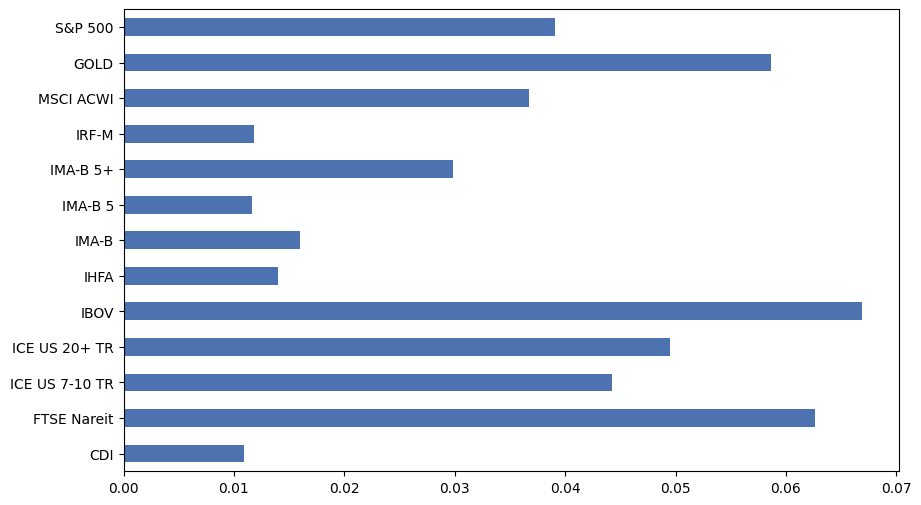

In [ ]:
buffer_period = 60
assets_returns_sample = assets_returns_selected_complete.iloc[0:buffer_period,] #Subset returns
historical_mean_returns = assets_returns_sample.mean() #Take historical means
historical_sd_returns = assets_returns_sample.std() #Take historical means
historical_sharpe = historical_mean_returns/historical_sd_returns #Take Sharpe

expected_returns_1y_period = expected_returns_1y.iloc[(d-buffer_period)//12,] #Int dividsion

historical_cov_matrix = np.cov(assets_returns_sample,
                                   rowvar = False) #Each col represents a variable


#historical_mean_returns.plot.barh(figsize=(10,6));
#historical_sd_returns.plot.barh(figsize=(10,6));
#historical_sharpe.plot.barh(figsize=(10,6));

expected_returns_5y_period.plot.barh(figsize=(10,6));


EW Portfolios

In [ ]:
#EW Portfolio
num_assets = len(historical_mean_returns)
ew_weights = 1/num_assets

Max Return Conservador - Histórico

MVO - Max Return

/usr/local/lib/python3.10/dist-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
<ipython-input-59-67b4c4078146>:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  weights_backtest_mvo = pd.concat([weights_backtest_mvo, pd.DataFrame(weights_mvo, index=[new_index])])
/usr/local/lib/python3.10/dist-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your pro

Rebalancing Period nº
60
105   -0.003375
106    0.025524
107    0.031237
108    0.016829
109    0.012582
110    0.012653
111    0.004147
112    0.012097
113    0.004681
114    0.008980
115    0.008217
116    0.005407
dtype: float64
Rebalancing Period nº
72
117    0.005867
118    0.007539
119    0.007119
120    0.010928
121    0.006124
122    0.008334
123    0.004119
124    0.010017
125    0.008775
126    0.010402
127    0.010749
128    0.006443
dtype: float64
Rebalancing Period nº
84
129    0.010084
130    0.006197
131    0.008868
132    0.006089
133    0.008706
134    0.010046
135    0.008370
136    0.010419
137    0.007754
138    0.009248
139    0.020994
140    0.016041
dtype: float64
Rebalancing Period nº
96
141    0.006873
142    0.012132
143    0.007562
144    0.010580
145    0.009336
146    0.010373
147    0.012645
148    0.010422
149    0.007899
150    0.010296
151    0.006492
152    0.006951
dtype: float64
Rebalancing Period nº
108
153    0.010186
154    0.006772
155    0.00740

/usr/local/lib/python3.10/dist-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.10/dist-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.10/dist-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning

Rebalancing Period nº
120
165    0.007709
166    0.007529
167    0.008955
168    0.004513
169    0.011149
170    0.005466
171    0.008043
172    0.011414
173    0.007980
174    0.009736
175    0.010767
176    0.008011
dtype: float64
Rebalancing Period nº
132
177    0.008575
178    0.012778
179    0.007444
180    0.012294
181    0.014079
182    0.014966
183    0.004076
184    0.015495
185    0.005504
186    0.019753
187    0.004187
188    0.009772
dtype: float64
Rebalancing Period nº
144
189    0.012156
190    0.009730
191    0.011271
192    0.017216
193    0.011018
194    0.011714
195    0.016413
196    0.009761
197    0.010544
198    0.012696
199    0.011340
200    0.013262
dtype: float64
Rebalancing Period nº
156
201    0.009553
202    0.008481
203    0.012996
204    0.012875
205    0.012812
206    0.012248
207    0.007040
208    0.005128
209    0.009540
210    0.013927
211    0.009930
212    0.009901
dtype: float64


/usr/local/lib/python3.10/dist-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.10/dist-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.10/dist-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning

Rebalancing Period nº
168
213    0.006117
214    0.003221
215    0.008712
216    0.010406
217    0.005913
218    0.008764
219    0.006333
220   -0.002456
221    0.005066
222    0.008739
223    0.005151
224    0.005535
dtype: float64
Rebalancing Period nº
180
225    0.011427
226    0.007059
227    0.005501
228    0.010138
229    0.005335
230    0.007091
231    0.007448
232    0.007772
233    0.011356
234    0.006921
235    0.007918
236    0.008631
dtype: float64
Rebalancing Period nº
192
237    0.008397
238    0.003793
239    0.006196
240    0.008302
241    0.002430
242   -0.004119
243    0.013220
244    0.010387
245    0.007134
246    0.006766
247    0.004534
248   -0.002172
dtype: float64
Rebalancing Period nº
204
249    0.000349
250    0.004641
251    0.009081
252    0.000806
253   -0.001495
254    0.002333
255    0.004028
256    0.002409
257    0.001008
258    0.002115
259    0.002288
260    0.004355
dtype: float64


/usr/local/lib/python3.10/dist-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.10/dist-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.10/dist-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning

Rebalancing Period nº
216
261    0.000029
262    0.009337
263    0.010283
264    0.001501
265    0.004867
266    0.009345
267    0.006108
268    0.007118
269    0.008880
270    0.011084
271    0.009781
272    0.008472
dtype: float64
Rebalancing Period nº
228
273    0.011660
274    0.005767
275    0.007965
276    0.012005
277    0.008132
278    0.012652
279    0.008764
280    0.011970
281    0.011072
282    0.010074
283    0.009219
284    0.005033
dtype: float64
Rebalancing Period nº
240
285    0.004613
286    0.015829
287    0.012651
288    0.008926
dtype: float64


,CDI,FTSE Nareit,ICE US 7-10 TR,ICE US 20+ TR,IBOV,IHFA,IMA-B,IMA-B 5,IMA-B 5+,IRF-M,MSCI ACWI,GOLD,S&P 500
2008-10-01,0.37760,0.0,0.02322,0.0,0.0,0.08435,0.00893,0.18136,0.0,0.30920,0.0,0.01533,0.00000
2009-10-01,0.53888,0.0,0.02314,0.0,0.0,0.10459,0.00000,0.11857,0.0,0.21482,0.0,0.00000,0.00000
2010-10-01,0.53668,0.0,0.02250,0.0,0.0,0.10434,0.00000,0.12773,0.0,0.20876,0.0,0.00000,0.00000
2011-10-01,0.54144,0.0,0.01596,0.0,0.0,0.10965,0.00000,0.12574,0.0,0.20663,0.0,0.00000,0.00059
2012-10-01,0.51340,0.0,0.01417,0.0,0.0,0.11599,0.00000,0.13756,0.0,0.20991,0.0,0.00000,0.00897
2013-10-01,0.55174,0.0,0.01385,0.0,0.0,0.12144,0.00000,0.12001,0.0,0.17392,0.0,0.00000,0.01904
2014-10-01,0.53044,0.0,0.01543,0.0,0.0,0.13210,0.00000,0.12668,0.0,0.17386,0.0,0.00000,0.02150
2015-10-01,0.53616,0.0,0.01273,0.0,0.0,0.10891,0.00000,0.12067,0.0,0.20648,0.0,0.00000,0.01505
2016-10-01,0.52684,0.0,0.01294,0.0,0.0,0.11778,0.00000,0.13932,0.0,0.18531,0.0,0.00000,0.01780
2017-10-01,0.51042,0.0,0.01428,0.0,0.0,0.11823,0.00000,0.14281,0.0,0.19391,0.0,0.00000,0.02035


mean ret:
0.008396137950795609
sd ret:
0.004580987566446898
sharpe ret:
1.832822689214984


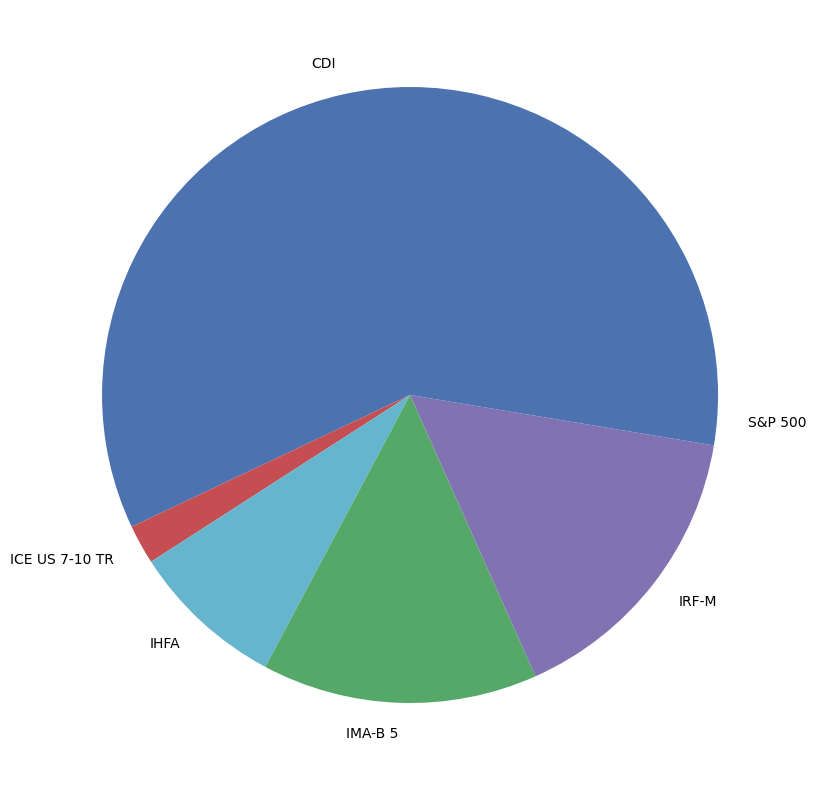

In [ ]:
###MAX RETURN - Expectativas + Historical
#######################################
from sklearn.covariance import LedoitWolf
from pypfopt.risk_models import CovarianceShrinkage

number_of_periods = assets_returns_selected_complete.shape[0] #Number of periods
buffer_period = 60 #Buffer period
rebalancing_freq = 12 #Annual rebalancing
rebalancing_periods = (number_of_periods - buffer_period)//12 #How many periods of rebalancing
last_rebalancing = (rebalancing_periods * 12) + buffer_period #Last rebalancing

weights_backtest_mvo = pd.DataFrame(columns=assets_returns_selected_complete.columns)  # Initialize DataFrame with asset names

returns_backtest_mvo = [] #Int list ot store returns

#Parameters
shrinkage_parameter_mean_ret = 0.5 #How much to shrink estimates to historical avg?
target_risk = 0.004 #Risk Budget
gamma_constraint = 0.01 #Diversification constraint 0.0050 is a good call for mvo at 0.5 shrinkage

#Rebalancing dates
dates = []
for year in list(range(2008, 2024)):
    date = datetime.date(year, 10, 1)
    dates.append(date)

date_vector = np.array(dates)


for d in range(buffer_period, number_of_periods, rebalancing_freq):
    #Get sample and calculate inputs
    assets_returns_sample = assets_returns_selected_complete.iloc[0:d,]  # Subset returns

    historical_mean_returns_period = assets_returns_sample.mean()
    historical_cov_matrix_period = np.cov(assets_returns_sample, rowvar=False)

    shrunk = LedoitWolf().fit(assets_returns_sample)   #Numpy
    shrunk_cov = shrunk.covariance_

    #shrunk = CovarianceShrinkage(assets_returns_sample, returns_data = True).ledoit_wolf()
    #shrunk_cov = shrunk/100
    expected_returns_period = expected_returns_5y.iloc[(d-buffer_period)//12,] #Int dividsion
    #Shrink to mean avg
    shrunk_mean_ret = historical_mean_returns_period*shrinkage_parameter_mean_ret + expected_returns_period*(1-shrinkage_parameter_mean_ret)

    # Optimization
    ##############################
    ef_mvo = EfficientFrontier(shrunk_mean_ret, historical_cov_matrix_period) #Create instance
    ef_mvo.add_sector_constraints(sector_mapper=class_mapper, sector_upper=class_upper, sector_lower=class_lower) #Sector constraints
    ef_mvo.add_objective(objective_functions.L2_reg, gamma = gamma_constraint) #gamma is tuning parm
    ef_mvo.efficient_risk(target_volatility=target_risk) #Set target vol
    weights_mvo = ef_mvo.clean_weights()

    # Append to DataFrame
    new_index = 0 if len(weights_backtest_mvo) == 0 else weights_backtest_mvo.index[-1] + 1
    weights_backtest_mvo = pd.concat([weights_backtest_mvo, pd.DataFrame(weights_mvo, index=[new_index])])

    # Take out-of-sample returns
    oos_length = (number_of_periods - last_rebalancing) if d == last_rebalancing else rebalancing_freq  # Determine the length of the out-of-sample period. If last period, oos_length = to remaining periods
    assets_returns_oos = assets_returns_selected_complete.iloc[d:d + oos_length,]

    # Calculate port out-of-sample returns
    returns_times_weights = assets_returns_oos * weights_mvo
    returns_backtest_mvo.append(returns_times_weights.sum(axis=1))
    print("Rebalancing Period nº")
    print(d)
    print(returns_times_weights.sum(axis=1))

# Convert the list of returns to a numpy array
returns_backtest_mvo = np.concatenate(returns_backtest_mvo)


weights_backtest_mvo.index = date_vector #Set rownames as dates
display(weights_backtest_mvo)


#Calculate some metrics
mean_ret_backtest_mvo = np.mean(returns_backtest_mvo) #Take mean ret
sd_ret_backtest_mvo = np.std(returns_backtest_mvo) #Take std
sharpe_ret_backtest_mvo = mean_ret_backtest_mvo/sd_ret_backtest_mvo #Take Sharpe

print("mean ret:")
print(mean_ret_backtest_mvo)

print("sd ret:")
print(sd_ret_backtest_mvo)

print("sharpe ret:")
print(sharpe_ret_backtest_mvo)

#Plot
#print(weights_mvo)
pd.Series(weights_mvo).plot.pie(figsize=(10,10));

#Efficient Frontier
#cla = CLA(historical_mean_returns, historical_cov_matrix)
#cla.max_sharpe()
#cla.portfolio_performance(verbose=True);
#ax = plotting.plot_efficient_frontier(cla, showfig=False)

In [ ]:
import pandas as pd

returns_backtest_mvo_df = pd.DataFrame(returns_backtest_mvo)
returns_backtest_mvo_df.to_excel('mvo.xlsx', sheet_name='Sheet1')

# Download the file to your local computer (optional)
from google.colab import files
files.download('mvo.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Set constraints for Risk Parity

In [ ]:
asset_classes = {'Assets': ['CDI','FTSE Nareit','ICE US 7-10 TR','ICE US 20+ TR','IBOV','IHFA','IMA-B','IMA-B 5',
                            'IMA-B 5+','IRF-M','MSCI ACWI','GOLD','S&P 500'],
                 'Industry': ['RF','Exterior',
                              'Exterior', 'Exterior',
                              'RV','Estruturado','RF',
                              'RF','RF','RF',
                              'Exterior','Gold','Exterior']}

asset_classes = pd.DataFrame(asset_classes)
asset_classes = asset_classes.sort_values(by=['Assets'])

constraints = {'Disabled': [False, False, False, False, False,False],
               'Type': ['All Assets', 'Classes', 'Classes', 'Classes',
                        'Classes', 'Classes'],
               'Set': ['', 'Industry', 'Industry', 'Industry', 'Industry', 'Industry'],
               'Position': ['', 'RF', 'Exterior', 'RV',
                            'Estruturado', 'Gold'],
               'Sign': ['<=', '<=', '<=', '<=', '<=', '<='],
               'Weight': [1, 1, 0.1, 0.7, 0.15, 0.03],
               'Type Relative': ['', '', '', '', '',''],
               'Relative Set': ['', '', '', '', '',''],
               'Relative': ['', '', '', '', '',''],
               'Factor': ['', '', '', '', '','']}

constraints = pd.DataFrame(constraints)

display(constraints)

,Disabled,Type,Set,Position,Sign,Weight,Type Relative,Relative Set,Relative,Factor
0,False,All Assets,,,<=,1.00,,,,
1,False,Classes,Industry,RF,<=,1.00,,,,
2,False,Classes,Industry,Exterior,<=,0.10,,,,
3,False,Classes,Industry,RV,<=,0.70,,,,
4,False,Classes,Industry,Estruturado,<=,0.15,,,,
5,False,Classes,Industry,Gold,<=,0.03,,,,


RiskParity

In [ ]:
###Risk Parity - Expectativas + Historical
#######################################
import riskfolio as rp

number_of_periods = assets_returns_selected_complete.shape[0] #Number of periods
buffer_period = 60 #Buffer period
rebalancing_freq = 12 #Annual rebalancing
rebalancing_periods = (number_of_periods - buffer_period)//12 #How many periods of rebalancing
last_rebalancing = (rebalancing_periods * 12) + buffer_period #Last rebalancing

weights_backtest_mvo = pd.DataFrame(columns=assets_returns_selected_complete.columns)  # Initialize DataFrame with asset names

returns_backtest_mvo = [] #Int list ot store returns

#Parameters
shrinkage_parameter_mean_ret = 0.5 #How much to shrink estimates to historical avg?
target_risk = 0.02 #Risk Budget
gamma_constraint = 0.05 #Diversification constraint 0.0050 is a good call for mvo at 0.5 shrinkage
lower_ret_percentage = 1.375 #Min return

#Rebalancing dates
dates = []
for year in list(range(2008, 2024)):
    date = datetime.date(year, 10, 1)
    dates.append(date)

date_vector = np.array(dates)


for d in range(buffer_period, number_of_periods, rebalancing_freq):
    #Get sample and calculate inputs
    assets_returns_sample = assets_returns_selected_complete.iloc[0:d,]  # Subset returns

    historical_mean_returns_period = assets_returns_sample.mean()
    historical_cov_matrix_period = np.cov(assets_returns_sample, rowvar=False)

    expected_returns_period = expected_returns_5y.iloc[(d-buffer_period)//12,] #Int dividsion
    #Shrink to mean avg
    shrunk_mean_ret = historical_mean_returns_period*shrinkage_parameter_mean_ret + expected_returns_period*(1-shrinkage_parameter_mean_ret)

    #Set risk-free
    risk_free_period = shrunk_mean_ret.values[0]*lower_ret_percentage
    print(risk_free_period)


    # Risk Parity Portfolios
    ##############################
    port = rp.Portfolio(returns = assets_returns_sample)
    port.assets_stats(method_mu='hist', method_cov='hist', d=0.94)
    A, B = rp.assets_constraints(constraints, asset_classes)
    port.ainequality = A
    port.binequality = B
    port.lowerret = risk_free_period
    weights_mvo = port.rp_optimization(model='Classic', rm='MV', rf=0, b=None, hist=True)

    # Append the weights_mvo as a new row to weights_backtest_mvo
    weights_backtest_mvo.loc[len(weights_backtest_mvo)] = weights_mvo.values.flatten()

    # Take out-of-sample returns
    oos_length = (number_of_periods - last_rebalancing) if d == last_rebalancing else rebalancing_freq  # Determine the length of the out-of-sample period. If last period, oos_length = to remaining periods
    assets_returns_oos = assets_returns_selected_complete.iloc[d:d + oos_length,]

    # Calculate port out-of-sample returns
    returns_times_weights = assets_returns_oos * weights_mvo.values.flatten()
    returns_backtest_mvo.append(returns_times_weights.sum(axis=1))
    #print("Rebalancing Period nº")
    #print(d)
    #print(returns_times_weights.sum(axis=1))

# Convert the list of returns to a numpy array
returns_backtest_mvo = np.concatenate(returns_backtest_mvo)

weights_backtest_mvo.index = date_vector #Set rownames as dates
display(weights_backtest_mvo)


#Calculate some metrics
mean_ret_backtest_mvo = np.mean(returns_backtest_mvo) #Take mean ret
sd_ret_backtest_mvo = np.std(returns_backtest_mvo) #Take std
sharpe_ret_backtest_mvo = mean_ret_backtest_mvo/sd_ret_backtest_mvo #Take Sharpe

print("mean ret:")
print(mean_ret_backtest_mvo)

print("sd ret:")
print(sd_ret_backtest_mvo)

print("sharpe ret:")
print(sharpe_ret_backtest_mvo)

#Plot
#print(weights_mvo)
# Plot pie chart of portfolio weights
weights_mvo.plot.pie(subplots=True, figsize=(10, 10), legend=None);
ax = rp.plot_pie(w=weights_mvo, title='Risk Parity Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,6))

# Plotting the risk composition of the portfolio
ax = rp.plot_risk_con(weights_mvo, cov=port.cov, returns=port.returns, rm='MV', rf=0, alpha=0.05,
                      color="tab:blue", height=6, width=10, ax=ax)

# Plotting equal risk contribution line
a1 = rp.Sharpe_Risk(weights_mvo, cov=port.cov, returns=port.returns, rm='MV', rf=0, alpha=0.05)
ax.axhline(y=a1/13 * 252**0.5, color='r', linestyle='-')

plt.show()
#Efficient Frontier
#cla = CLA(historical_mean_returns, historical_cov_matrix)
#cla.max_sharpe()
#cla.portfolio_performance(verbose=True);
#ax = plotting.plot_efficient_frontier(cla, showfig=False)

0.014622023358516659
0.013100509134986189
0.013070542515576796
0.01285456606709381
0.011548344580848883
0.0119937010158466
0.012451912657035191
0.012850065434613093
The problem doesn't have a solution with actual input parameters


AttributeError: 'NoneType' object has no attribute 'values'